0 -> 2
0 -> 1
Key node, value: parents {2: [0], 1: [0]}
Conditional Probability Table: 
 [['0', '0', 0.09616768208281934], ['0', '1', 0.9038323179171807], ['1', '0', 0.01783141027503154], ['1', '1', 0.9821685897249685]]
Conditional Probability Table: 
 [['0', '0', 0.04515557938381212], ['0', '1', 0.9548444206161879], ['1', '0', 0.8787129315229836], ['1', '1', 0.12128706847701641]]
Root node:  0  dist:  {'0': 0.5327727065852401, '1': 0.46722729341475977}
States created for all nodes!
Network has  3  nodes
Network has  2  edges


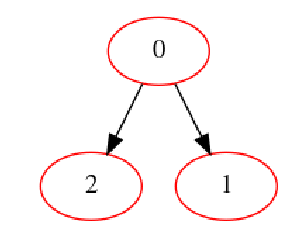

In [87]:

from pomegranate import *

import networkx as nx
from random import randint
import  itertools
import numpy as np

class RandomDAG:
    def __init__(self):
        self.randDAG = nx.DiGraph()

    # connected graph req (n-1) edges at least
    # DAG can't be more than n(n-1) edges
    # https://ipython.org/ipython-doc/3/parallel/dag_dependencies.html
    def random_dag(self, n_nodes, n_edges):
        self.n_nodes = n_nodes
        self.n_edges = n_edges
        child_parent = {}

        if n_edges > n_nodes * (n_nodes - 1):
            self.n_edges = n_nodes * (n_nodes - 1)

        """Generate a random Directed Acyclic Graph (DAG) with a given number of nodes and edges."""
        self.randDAG = nx.DiGraph()
        # add nodes, labeled 0...nodes:
        for i in range(self.n_nodes):
            self.randDAG.add_node(i)

        # to avoid infinit loop, need to have better solution
        round = 1000
        while self.n_edges > 0 and round > 0:
            round -= 1

            a = randint(0, self.n_nodes - 1)
            b = a
            while b == a or self.randDAG.has_edge(a, b):
                b = randint(0, self.n_nodes - 1)
            self.randDAG.add_edge(a, b)
            if nx.is_directed_acyclic_graph(self.randDAG):
                self.n_edges -= 1
                parent = child_parent.get(b)
                if parent is None:
                    parent = [a]
                else:
                    parent.append(a)
                child_parent[b] = parent
                # print(a,"-> ", b)
            else:
                # we closed a loop!
                self.randDAG.remove_edge(a, b)

        return self.randDAG, child_parent


# from https://github.com/jmschrei/pomegranate/blob/master/examples/bayesnet_asia.ipynb
class User_model:

    def getCondProbTable(self, n_var, n_att):
        var = range(n_var)
        var_att_dict = {}
        for i in var:
            var_att_dict[i] = [ str(c) for c in range(n_att)]
            # var_att_dict[i] = [ chr(c) for c in range(65, 65+n_att)]
            #list(range(n_att))
        if sys.version_info.major > 2:  # python3
            permutation = list(dict(zip(var_att_dict, x)) for x in itertools.product(*var_att_dict.values()))

        #print(permutation, ", ", len(permutation), "\n")
        condProbTable = []
        # for each permutation generate prob such that the sum is = 1
        for i in range(int(len(permutation) / n_att)):
            a = np.random.random(n_att)
            a /= a.sum()
            # to make sum of alter prob = 1
            for j in range(n_att):
                condProbRow = list(permutation[i *n_att + j].values())
                condProbRow.append(a[j])
               # print(permutation[i *n_att + j], " = ", a[j])
               # print(condProbRow)
                condProbTable.append(condProbRow)
        return condProbTable

    # n_types: number devices types (e.g. door_lock, camera, etc)
    # n_alter: number of devices from same type
    # n_types: number devices types (e.g. door_lock, camera, etc)
    # n_alter: number of devices from same type
    def get_BN(self, n_nodes, n_alters, n_edges):

        # 1 Build BN DAG structure
        DAG, child_parent = RandomDAG().random_dag(n_nodes, n_edges)
        
        for a, bs in DAG.edge.items():
            for b in bs.keys():
                print(a, "->", b)
        print("Key node, value: parents",child_parent)

        # 2 Build BN probability model
        # 2.1 get probabilityDist or conditional prob table
        node_prob_dict = {}
        # these nodes have parents, generate CPT for them
        for node, parent_lst in child_parent.items():
            # parents + this node condProbTable
            condProbTable = self.getCondProbTable(len(parent_lst)+1, n_alters)
            # save node with its prob
            node_prob_dict[str(node)] = condProbTable
            print("Conditional Probability Table: \n", condProbTable)

        nodes_list = list(range(n_nodes))
        node_with_parent_lst = child_parent.keys()
        node_without_parents = [e for e in nodes_list if e not in node_with_parent_lst]

        # these nodes have no parents so create random prob for them only no conditional here
        for node in node_without_parents:
            p = np.random.random(n_alters)
            p /= p.sum()
            dist = {}
            for j in range(n_alters):
                dist[str(j)] = p[j]
            # save node with its prob
                node_prob_dict[str(node)] = dist
            print("Root node: ", node, " dist: ", dist)

        # 2.2 Create nodes linked to its parent, parent should be processed first.
        # all node state saved to be added to the BN later
        nodes_state = {}
        # all node dist or CPT saved to link child to parents when building child CPT
        nodes_dist = {}

        # start with root nodes (don't have parents then link child to them)
        for node in node_without_parents:
            prob_dist = node_prob_dict[str(node)]
            node_dist = DiscreteDistribution(prob_dist)
            nodes_dist[node] = node_dist
            nodes_state[node] = State(node_dist, name = str(node))
            # remove from nodes_list
            nodes_list.remove(node)


        # rest of the node should have parents
        count = 100
        while len(nodes_list) > 0 and count > 0:
            count -= 1
            for node, parent_lst in child_parent.items():
                # if node's parents already created then it can be created now
                if set(parent_lst).issubset(nodes_state.keys()) and node in nodes_list:

                    node_dist = ConditionalProbabilityTable(node_prob_dict[str(node)] \
                                                      , [nodes_dist[i] for i in parent_lst ])
                    nodes_dist[node] = node_dist
                    nodes_state[node] = State(node_dist, name = str(node))
                    # remove from the node_list
                    nodes_list.remove(node)
        if not nodes_list:
            print("States created for all nodes!")

        # 3 Create BN and add the nodes_state
        network = BayesianNetwork("User_pref")
        for node, state in nodes_state.items():
            network.add_node(state)
        print("Network has ", network.node_count() , " nodes")

        # 4 Link nodes with edges using nodes_state and DAG.edge
        for a, bs in DAG.edge.items():
            for b in bs.keys():
                network.add_edge(nodes_state[a], nodes_state[b])
        print("Network has ", network.edge_count(), " edges")
        return network

user_model = User_model()
network = user_model.get_BN(n_nodes = 3, n_alters = 2, n_edges=2)
network.bake()
network.probability(['0','0','0'])
network.plot()